In [5]:
import numpy as np
import matplotlib.pyplot as plt
from q3dfit.q3din import q3din
from q3dfit.q3dout import load_q3dout
from astropy.io import fits
from specutils import Spectrum1D
from scipy.interpolate import interp1d
from photutils import centroids
from astropy.coordinates import SkyCoord
from glob import glob
from astropy import units as u

# Importing Data
The variable cubes should be a list of paths for filenames for the end products of the jwst pipeline. Note: I've only tried this with cubes across entire channels but I think it would work if the end product was band specific. 


In [7]:
### Put cube location and RA/DEC of center here
input_dir = 'F08572+3915-NW/s3d_files/'
cubes = sorted(glob(input_dir+'*_s3d.fits'))
center_coord = SkyCoord('09 00 25.3640','+39 03 54.23', unit=(u.hourangle, u.deg))

### If correcting with WISE data, put correction factor here
#corrx, corry = np.genfromtxt('poly_corr_flat.txt')
#plt.plot(corrx, corry)
#del cubes[4-1::4]

cubes

['F08572+3915-NW/s3d_files/jw03869-o005_t005_miri_ch1-shortmediumlong_s3d.fits',
 'F08572+3915-NW/s3d_files/jw03869-o005_t005_miri_ch2-shortmediumlong_s3d.fits',
 'F08572+3915-NW/s3d_files/jw03869-o005_t005_miri_ch3-shortmediumlong_s3d.fits',
 'F08572+3915-NW/s3d_files/jw03869-o005_t005_miri_ch4-shortmediumlong_s3d.fits']

# Correcting
This notebook should increase the general time and wavelength dependent correction factor implemented by the jwst pipeline due a sensitivity drop. While not perfect we have modeled this correction factor as a smooth polynomial (based on the jwst correction) that is scaled with a power law to account for the time dependence. The wavelength dependent drop is fairly constant source to source so the only parameter that needs changing is time dependent factor.

We determined the correction factors for PDS456 and F2M1106 by bringing the jwst data within the error bars of WISE data from the same source. With the limited data set correction factors should be determined source to source. 

23.438583836173123 23.385287779254515
19.626198567344137 19.237463547985527
24.465552495479752 19.75507072833408
14.920541586782388 17.350881675200018


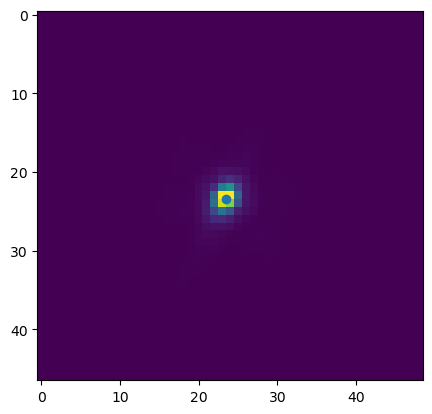

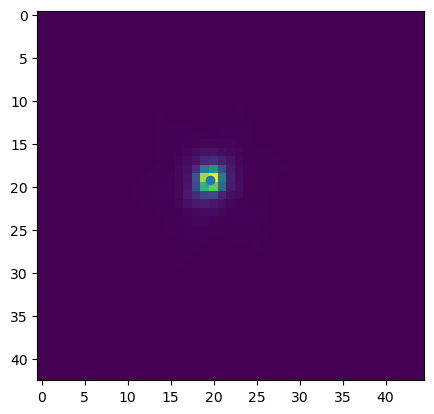

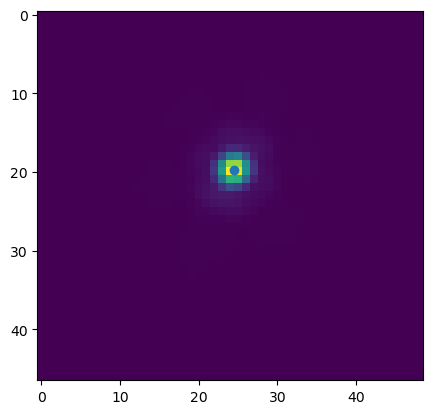

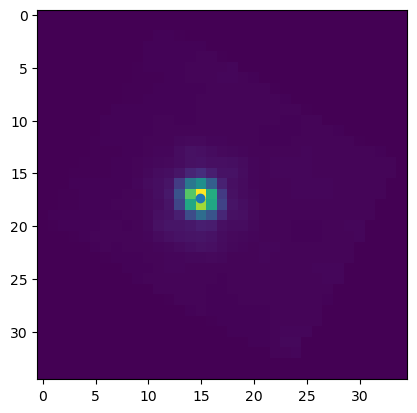

In [11]:
##### Change based on observation date #########
#corr_factor = 0.2 ## 02-04-2023 (PDS 456)
#corr_factor = 0.55 ## 21-11-2022 (F2M1106)
                    ## 24-11-2022 (XID 2028)
#corr_factor = 0.75 ## 27-07-2023 (Phoenix BCG)

correct_wise = False
align = True
write_to_header = True
plot_centers = True

for i, name in enumerate(cubes):
    hdul = fits.open(name)
    if correct_wise == True:
        q3di = q3din(name, 'test', datext=1, varext=2, dqext=3, 
                     outdir=input_dir+'test/', 
                     logfile=input_dir+'test/ch'+str(i+1)+'-fitlog.txt') #specutils didn't work, so I used q3d to grab wl array
        wav = q3di.load_cube().wave
        #spec1d = Spectrum1D.read(name)
        #wav = np.array(spec1d.spectral_axis.value)
        corr_interp = interp1d(corrx, corry)(wav)
        
        # uncomment the lines below to show the old and corrected spectra for an individual spaxel
        plt.plot(wav, hdul[2].data[:, 21, 21], color='black') 
        for j in range(hdul[1].data.shape[1]):
            for k in range(hdul[1].data.shape[2]):
                hdul[1].data[:, j, k] = hdul[1].data[:, j, k]*corr_interp**corr_factor
                hdul[2].data[:, j, k] = hdul[2].data[:, j, k]*corr_interp**corr_factor
        plt.plot(wav, hdul[2].data[:, 21, 21], color='red') 
        plt.ylim(-50, 200)    
    # correcting header
    if align == True:
        cube_sum = np.sum(np.nan_to_num(hdul[1].data), axis=0)
        x1,y1 = centroids.centroid_1dg(cube_sum) #centroid_com not working well
        print(x1,y1)
        hdul[1].header['CRPIX1'] = x1+1.
        hdul[1].header['CRPIX2'] = y1+1.
        hdul[1].header['CRVAL1'] = center_coord.ra.deg # center RA
        hdul[1].header['CRVAL2'] = center_coord.dec.deg # center DEC
        if write_to_header == True:
            hdul.writeto(name[:-5] + '_corr.fits', overwrite=True)
    if plot_centers == True:
        plt.figure()
        plt.imshow(cube_sum)
        plt.scatter(x1,y1)
    